# Exploring the TensorFlow models

In this notebook we will utilise some simple dense neural networks in finding Ricci-flat Calabi-Yau metrics. 
In particular we will make use of the following three tensorflow models.

1. *MultFSModel*: uses the following Ansatz for the CY metric: $g_{pred} = g_{FS} ( 1 + g_{NN})$.
2. *PhiFSModel*: uses the following Ansatz for the CY metric: $g_{pred} = g_{FS} + \partial \bar{\partial} \phi_{NN}$.
2. *ToricPhiFSModel*: is the same as *PhiFSModel*, but for toric CYs.

This notebook assumes that [1.PointGenerator](1.PointGenerator.ipynb) has generated datasets for the Fermat quintic.

In [1]:
import numpy as np
import os as os
import tensorflow as tf
tfk = tf.keras

## MultFSModel 

The *MultFSModel* works for any CICY.

### Data preprocessing

We load the dataset and also the generated basis from *PointGenerator*

In [2]:
dirname = 'fermat_pg'

In [3]:
data = np.load(os.path.join(dirname, 'dataset.npz'))
BASIS = np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True)

tensorflow can only compute derivatives w.r.t. tensor objects. Thus we transform the *BASIS* using

In [4]:
from cymetric.models.tfhelper import prepare_tf_basis, train_model

In [5]:
BASIS = prepare_tf_basis(BASIS)

Our integration weights set the overall volume of the CY. This parameter is usually denoted with $\kappa$ and contributes directly in the MA equation.

In [6]:
kappa = np.real(BASIS['KAPPA'].numpy());
kappa

0.017589772

### NN set up

The *cymetric*-TensorFlow models are custom models and come with custom needs. We have written several callbacks and metrics to track the training progress.

In [7]:
from cymetric.models.callbacks import RicciCallback, SigmaCallback, VolkCallback, KaehlerCallback, TransitionCallback
from cymetric.models.tfmodels import MultFSModel
from cymetric.models.metrics import SigmaLoss, KaehlerLoss, TransitionLoss, VolkLoss, RicciLoss, TotalLoss

We define some callbacks to evaluate the performance of our models on the

1. Ricci-measure
2. Sigma-measure
3. Volume

In [8]:
rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
scb = SigmaCallback((data['X_val'], data['y_val']))
volkcb = VolkCallback((data['X_val'], data['y_val']))
kcb = KaehlerCallback((data['X_val'], data['y_val']))
tcb = TransitionCallback((data['X_val'], data['y_val']))
cb_list = [rcb, scb, kcb, tcb, volkcb]

set some hyperparameters for the NN

In [9]:
nlayer = 3
nHidden = 64
act = 'gelu'
nEpochs = 50
bSizes = [64, 50000]
alpha = [1., 1., 1., 1., 1.]
nfold = 3
n_in = 2*5
n_out = nfold**2

and finally set up the neural net

In [10]:
nn = tf.keras.Sequential()
nn.add(tfk.Input(shape=(n_in)))
for i in range(nlayer):
    nn.add(tfk.layers.Dense(nHidden, activation=act))
nn.add(tfk.layers.Dense(n_out, use_bias=False))

In [11]:
help(MultFSModel)

Help on class MultFSModel in module cymetric.models.tfmodels:

class MultFSModel(FreeModel)
 |  MultFSModel(*args, **kwargs)
 |  
 |  MultFSModel inherits from :py:class:`FreeModel`.
 |  
 |  Example:
 |      Is identical to :py:class:`FreeModel`. Replace the model accordingly.
 |  
 |  Method resolution order:
 |      MultFSModel
 |      FreeModel
 |      cymetric.models.fubinistudy.FSModel
 |      keras.engine.training.Model
 |      keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.training.tracking.tracking.AutoTrackable
 |      tensorflow.python.training.tracking.base.Trackable
 |      keras.utils.version_utils.LayerVersionSelector
 |      keras.utils.version_utils.ModelVersionSelector
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      MultFSModel is a tensorflow model predicting CY metrics.
 |      
 |      The output of this model has the following Ansatz
 |      
 |      .. 

the *MultFSModel* requires as arguments 

1. the nn, which we have defined above, 
2. the *PointGenerator*-*BASIS* which contains all relevant information of the underlying Calabi-Yau.

It has optional arguments for

1. The overall volume of the CY. We give kappa to stay at the same volume as the integration weights.
2. alpha, which weights the different loss contributions (1-MA loss, 2-Kähler loss, 3-transition loss, 4-Ricci loss (by default disabled), 5-volk loss).

In [12]:
fmodel = MultFSModel(nn, BASIS, alpha=alpha)

we define some custom metrics to track our training progress and the optimizer

In [13]:
cmetrics = [TotalLoss(), SigmaLoss(), KaehlerLoss(), TransitionLoss(), VolkLoss(), RicciLoss()]
opt = tfk.optimizers.Adam()

compile and train the model

In [14]:
fmodel, training_history = train_model(fmodel, data, optimizer=opt, epochs=nEpochs, batch_sizes=[64, 50000], 
                                       verbose=1, custom_metrics=cmetrics, callbacks=cb_list)

Epoch  1/50


2022-04-03 19:37:10.976171: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 - Ricci measure val:      0.7817
 - Sigma measure val:      0.3694
 - Kaehler measure val:    3.6580e-04
 - Transition measure val: 0.0018
 - Volk val:               5.1957


/Users/ruehle/venv-ml/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_5_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_5_grad/Reshape:0", shape=(None,), dtype=complex64), dense_shape=Tensor("gradients/GatherV2_5_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/ruehle/venv-ml/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_4_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_4_grad/Reshape:0", shape=(None,), dtype=complex64), dense_shape=Tensor("gradients/GatherV2_4_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.

1406/1407 [============================>.] - ETA: 0s - loss: 0.1909 - sigma_loss: 0.1739 - kaehler_loss: 0.0055 - transition_loss: 0.0115 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      1.2833
 - Sigma measure val:      0.1056
 - Kaehler measure val:    0.0067
 - Transition measure val: 0.0104
 - Volk val:               4.9876
1407/1407 [==============================] - 39s 19ms/step - loss: 0.1908 - sigma_loss: 0.1738 - kaehler_loss: 0.0055 - transition_loss: 0.0115 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 1.2833 - sigma_val: 0.1056 - kaehler_val: 0.0067 - transition_val: 0.0104 - volk_val: 4.9876
 - Ricci measure val:      1.2833
 - Sigma measure val:      0.1056
 - Kaehler measure val:    0.0067
 - Transition measure val: 0.0104
 - Volk val:               4.9876
2/2 [==============================] - ETA: 0s - loss: 0.0357 - sigma_loss: 0.1042 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0000e+00 - volk_loss: 0.0357 - ricci_loss: 0

 - Transition measure val: 0.0027
 - Volk val:               5.3243
1405/1407 [============================>.] - ETA: 0s - loss: 0.0936 - sigma_loss: 0.0861 - kaehler_loss: 0.0049 - transition_loss: 0.0026 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      1.0510
 - Sigma measure val:      0.0920
 - Kaehler measure val:    0.0049
 - Transition measure val: 0.0026
 - Volk val:               4.9059
1407/1407 [==============================] - 28s 18ms/step - loss: 0.0936 - sigma_loss: 0.0861 - kaehler_loss: 0.0049 - transition_loss: 0.0026 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 1.0510 - sigma_val: 0.0920 - kaehler_val: 0.0049 - transition_val: 0.0026 - volk_val: 4.9059
 - Ricci measure val:      1.0510
 - Sigma measure val:      0.0920
 - Kaehler measure val:    0.0049
 - Transition measure val: 0.0026
 - Volk val:               4.9059
2/2 [==============================] - ETA: 0s - loss: 0.1536 - sigma_loss: 0.0929 - kaehler_loss: 0.0000e+

 - Volk val:               5.0941
1405/1407 [============================>.] - ETA: 0s - loss: 0.0891 - sigma_loss: 0.0818 - kaehler_loss: 0.0049 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      0.9914
 - Sigma measure val:      0.0859
 - Kaehler measure val:    0.0051
 - Transition measure val: 0.0024
 - Volk val:               4.8669
1407/1407 [==============================] - 28s 19ms/step - loss: 0.0890 - sigma_loss: 0.0817 - kaehler_loss: 0.0049 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 0.9914 - sigma_val: 0.0859 - kaehler_val: 0.0051 - transition_val: 0.0024 - volk_val: 4.8669
 - Ricci measure val:      0.9914
 - Sigma measure val:      0.0859
 - Kaehler measure val:    0.0051
 - Transition measure val: 0.0024
 - Volk val:               4.8669
2/2 [==============================] - ETA: 0s - loss: 0.2142 - sigma_loss: 0.0833 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0000e+00 -

 - Volk val:               5.0158
1404/1407 [============================>.] - ETA: 0s - loss: 0.0829 - sigma_loss: 0.0756 - kaehler_loss: 0.0049 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      0.9120
 - Sigma measure val:      0.0820
 - Kaehler measure val:    0.0049
 - Transition measure val: 0.0024
 - Volk val:               4.9261
1407/1407 [==============================] - 26s 17ms/step - loss: 0.0829 - sigma_loss: 0.0756 - kaehler_loss: 0.0049 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 0.9120 - sigma_val: 0.0820 - kaehler_val: 0.0049 - transition_val: 0.0024 - volk_val: 4.9261
 - Ricci measure val:      0.9120
 - Sigma measure val:      0.0820
 - Kaehler measure val:    0.0049
 - Transition measure val: 0.0024
 - Volk val:               4.9261
2/2 [==============================] - ETA: 0s - loss: 0.1482 - sigma_loss: 0.0759 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0000e+00 -

 - Transition measure val: 0.0023
 - Volk val:               5.2353
1406/1407 [============================>.] - ETA: 0s - loss: 0.0800 - sigma_loss: 0.0727 - kaehler_loss: 0.0049 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      0.8327
 - Sigma measure val:      0.0804
 - Kaehler measure val:    0.0051
 - Transition measure val: 0.0023
 - Volk val:               4.9644
1407/1407 [==============================] - 24s 16ms/step - loss: 0.0800 - sigma_loss: 0.0727 - kaehler_loss: 0.0049 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 0.8327 - sigma_val: 0.0804 - kaehler_val: 0.0051 - transition_val: 0.0023 - volk_val: 4.9644
 - Ricci measure val:      0.8327
 - Sigma measure val:      0.0804
 - Kaehler measure val:    0.0051
 - Transition measure val: 0.0023
 - Volk val:               4.9644
2/2 [==============================] - ETA: 0s - loss: 0.1141 - sigma_loss: 0.0754 - kaehler_loss: 0.0000e+

 - Volk val:               5.1854
1405/1407 [============================>.] - ETA: 0s - loss: 0.0754 - sigma_loss: 0.0676 - kaehler_loss: 0.0054 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      0.8050
 - Sigma measure val:      0.0715
 - Kaehler measure val:    0.0056
 - Transition measure val: 0.0024
 - Volk val:               5.0276
1407/1407 [==============================] - 25s 16ms/step - loss: 0.0753 - sigma_loss: 0.0676 - kaehler_loss: 0.0054 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 0.8050 - sigma_val: 0.0715 - kaehler_val: 0.0056 - transition_val: 0.0024 - volk_val: 5.0276
 - Ricci measure val:      0.8050
 - Sigma measure val:      0.0715
 - Kaehler measure val:    0.0056
 - Transition measure val: 0.0024
 - Volk val:               5.0276
2/2 [==============================] - ETA: 0s - loss: 0.0691 - sigma_loss: 0.0664 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0000e+00 -

 - Volk val:               5.1216
1407/1407 [==============================] - ETA: 0s - loss: 0.0656 - sigma_loss: 0.0570 - kaehler_loss: 0.0061 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      0.6068
 - Sigma measure val:      0.0573
 - Kaehler measure val:    0.0061
 - Transition measure val: 0.0024
 - Volk val:               5.0216
1407/1407 [==============================] - 25s 16ms/step - loss: 0.0656 - sigma_loss: 0.0570 - kaehler_loss: 0.0061 - transition_loss: 0.0024 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 0.6068 - sigma_val: 0.0573 - kaehler_val: 0.0061 - transition_val: 0.0024 - volk_val: 5.0216
 - Ricci measure val:      0.6068
 - Sigma measure val:      0.0573
 - Kaehler measure val:    0.0061
 - Transition measure val: 0.0024
 - Volk val:               5.0216
2/2 [==============================] - ETA: 0s - loss: 0.0647 - sigma_loss: 0.0545 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0000e+00 -

 - Volk val:               4.9809
1404/1407 [============================>.] - ETA: 0s - loss: 0.0394 - sigma_loss: 0.0331 - kaehler_loss: 0.0046 - transition_loss: 0.0017 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      0.3124
 - Sigma measure val:      0.0302
 - Kaehler measure val:    0.0046
 - Transition measure val: 0.0017
 - Volk val:               4.9670
1407/1407 [==============================] - 25s 16ms/step - loss: 0.0394 - sigma_loss: 0.0331 - kaehler_loss: 0.0046 - transition_loss: 0.0017 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 0.3124 - sigma_val: 0.0302 - kaehler_val: 0.0046 - transition_val: 0.0017 - volk_val: 4.9670
 - Ricci measure val:      0.3124
 - Sigma measure val:      0.0302
 - Kaehler measure val:    0.0046
 - Transition measure val: 0.0017
 - Volk val:               4.9670
2/2 [==============================] - ETA: 0s - loss: 0.1368 - sigma_loss: 0.0320 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0000e+00 -

 - Volk val:               5.0912
1407/1407 [==============================] - ETA: 0s - loss: 0.0265 - sigma_loss: 0.0213 - kaehler_loss: 0.0037 - transition_loss: 0.0015 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      0.1739
 - Sigma measure val:      0.0195
 - Kaehler measure val:    0.0037
 - Transition measure val: 0.0015
 - Volk val:               4.9953
1407/1407 [==============================] - 25s 16ms/step - loss: 0.0265 - sigma_loss: 0.0213 - kaehler_loss: 0.0037 - transition_loss: 0.0015 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 0.1739 - sigma_val: 0.0195 - kaehler_val: 0.0037 - transition_val: 0.0015 - volk_val: 4.9953
 - Ricci measure val:      0.1739
 - Sigma measure val:      0.0195
 - Kaehler measure val:    0.0037
 - Transition measure val: 0.0015
 - Volk val:               4.9953
2/2 [==============================] - ETA: 0s - loss: 0.1206 - sigma_loss: 0.0213 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0000e+00 -

 - Volk val:               5.0810
1406/1407 [============================>.] - ETA: 0s - loss: 0.0230 - sigma_loss: 0.0182 - kaehler_loss: 0.0034 - transition_loss: 0.0014 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      0.1501
 - Sigma measure val:      0.0179
 - Kaehler measure val:    0.0033
 - Transition measure val: 0.0014
 - Volk val:               4.9991
1407/1407 [==============================] - 25s 16ms/step - loss: 0.0230 - sigma_loss: 0.0182 - kaehler_loss: 0.0034 - transition_loss: 0.0014 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 0.1501 - sigma_val: 0.0179 - kaehler_val: 0.0033 - transition_val: 0.0014 - volk_val: 4.9991
 - Ricci measure val:      0.1501
 - Sigma measure val:      0.0179
 - Kaehler measure val:    0.0033
 - Transition measure val: 0.0014
 - Volk val:               4.9991
2/2 [==============================] - ETA: 0s - loss: 0.1086 - sigma_loss: 0.0200 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0000e+00 -

In the training process the ricci_loss is zero, because it has been disabled so we don't have to compute two additional derivatives during training. We keep track of the Ricci measure with the callbacks. The volume computed for the validation set (volk val) should be 5, which is $\int_X J^3$ for the quintic with Kahler parameter $t=1$.

In [15]:
for key in sorted(training_history.keys()):
    print(key)

kaehler_loss
kaehler_val
loss
ricci_loss
ricci_val
sigma_loss
sigma_val
transition_loss
transition_val
volk_loss
volk_val


### Fancy plots

and make some fancy plots. The packages below are not required for *cymetric*, so you might have to install them by hand.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")

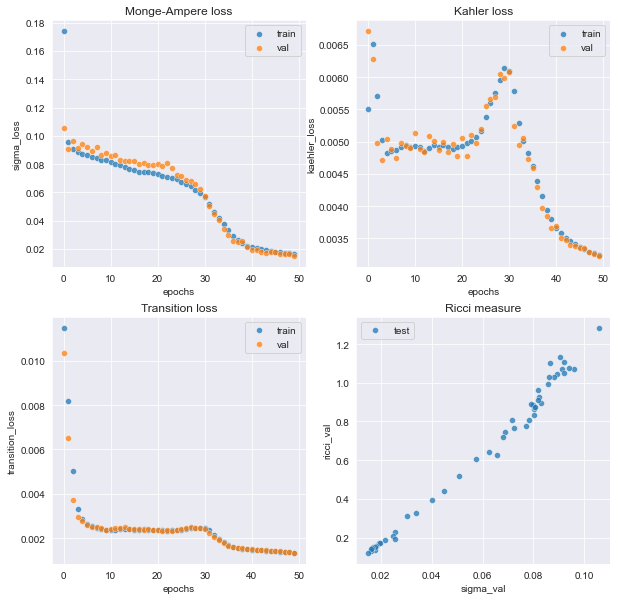

In [17]:
hist = training_history
hist['epochs'] = list(range(nEpochs))
hist_data = pd.DataFrame(hist)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title("Monge-Ampere loss")
sns.scatterplot(x='epochs', y='sigma_loss', data=hist_data, alpha=0.75, ax=ax1, label="train")
sns.scatterplot(x='epochs', y='sigma_val', data=hist_data, alpha=0.75, ax=ax1, label="val")

ax2.set_title("Kahler loss")
sns.scatterplot(x='epochs', y='kaehler_loss', data=hist_data, alpha=0.75, ax=ax2, label="train")
sns.scatterplot(x='epochs', y='kaehler_val', data=hist_data, alpha=0.75, ax=ax2, label="val")

ax3.set_title("Transition loss")
sns.scatterplot(x='epochs', y='transition_loss', data=hist_data, alpha=0.75, ax=ax3, label="train")
sns.scatterplot(x='epochs', y='transition_val', data=hist_data, alpha=0.75, ax=ax3, label="val")

ax4.set_title("Ricci measure")
sns.scatterplot(x='sigma_val', y='ricci_val', data=hist_data, alpha=0.75, ax=ax4, label="test");

and we find a nice slope going towards the origin for optimization of the MA equation.

## The PhiFSModel

is set up similar to the *MultFSModel*.

### The NN

now has a single output. We disable the bias in the last layer, because it's contribution will also be zero after taking the two derivatives w.r.t to the input coordinates.

In [18]:
n_out = 1
nn_phi = tf.keras.Sequential()
nn_phi.add(tfk.Input(shape=(n_in)))
for i in range(nlayer):
    nn_phi.add(tfk.layers.Dense(nHidden, activation=act))
nn_phi.add(tfk.layers.Dense(n_out, use_bias=False))

In [19]:
from cymetric.models.tfmodels import PhiFSModel

In [20]:
phimodel = PhiFSModel(nn_phi, BASIS, alpha=alpha)
opt_phi = tfk.optimizers.Adam()

and fit

In [21]:
phimodel, training_history = train_model(phimodel, data, optimizer=opt_phi, epochs=1, batch_sizes=[64, 50000], 
                                       verbose=1, custom_metrics=cmetrics, callbacks=cb_list)

Epoch  1/1
 - Ricci measure val:      0.6176
 - Sigma measure val:      0.4035
 - Kaehler measure val:    8.6788e-16
 - Transition measure val: 0.0112
 - Volk val:               4.5219
1407/1407 [==============================] - ETA: 0s - loss: 0.2276 - sigma_loss: 0.2202 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0074 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      1.1381
 - Sigma measure val:      0.1616
 - Kaehler measure val:    1.2552e-15
 - Transition measure val: 0.0029
 - Volk val:               4.7241
1407/1407 [==============================] - 19s 11ms/step - loss: 0.2276 - sigma_loss: 0.2202 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0074 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 1.1381 - sigma_val: 0.1616 - kaehler_val: 1.2552e-15 - transition_val: 0.0029 - volk_val: 4.7241
 - Ricci measure val:      1.1381
 - Sigma measure val:      0.1616
 - Kaehler measure val:    1.2694e-15
 - Transition measure val: 0.0029
 - V

we find that in addition to the ricci-loss also the kaehler-loss is zero. These latter is satisfied by construction in the $\phi$-network and thus disabled.

## The ToricPhiFSModel

requires additional toric data.

### The NN

is the same as for the *PhiFSModel*.

In [22]:
n_out = 1
nn_phit = tf.keras.Sequential()
nn_phit.add(tfk.Input(shape=(n_in)))
for i in range(nlayer):
    nn_phit.add(tfk.layers.Dense(nHidden, activation=act))
nn_phit.add(tfk.layers.Dense(n_out, use_bias=False))

In [23]:
from cymetric.models.tfmodels import PhiFSModelToric

load toric data

In [24]:
dirname = 'fermat_pgtoric'
toric_data = np.load(os.path.join(dirname, 'toric_data.pickle'), allow_pickle=True)

In [25]:
phimodel_toric = PhiFSModelToric(nn_phit, BASIS, alpha=alpha, toric_data=toric_data)
opt_phit = tfk.optimizers.Adam()

and fit

In [26]:
phimodel_toric, training_history = train_model(phimodel_toric, data, optimizer=opt_phit, epochs=1, batch_sizes=[64, 50000], 
                                       verbose=1, custom_metrics=cmetrics, callbacks=cb_list)

Epoch  1/1
 - Ricci measure val:      0.7352
 - Sigma measure val:      0.3731
 - Kaehler measure val:    8.1105e-16
 - Transition measure val: 0.0249
 - Volk val:               5.1903
1401/1407 [============================>.] - ETA: 0s - loss: 0.2984 - sigma_loss: 0.2582 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0402 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - Ricci measure val:      1.9562
 - Sigma measure val:      0.2037
 - Kaehler measure val:    1.0553e-15
 - Transition measure val: 0.0418
 - Volk val:               5.0570
1407/1407 [==============================] - 26s 12ms/step - loss: 0.2983 - sigma_loss: 0.2581 - kaehler_loss: 0.0000e+00 - transition_loss: 0.0402 - volk_loss: 0.0000e+00 - ricci_loss: 0.0000e+00 - ricci_val: 1.9562 - sigma_val: 0.2037 - kaehler_val: 1.0553e-15 - transition_val: 0.0418 - volk_val: 5.0570
 - Ricci measure val:      1.9562
 - Sigma measure val:      0.2037
 - Kaehler measure val:    1.0369e-15
 - Transition measure val: 0.0372
 - V